In [1]:
import msprime, tskit, pyslim, time 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sys
import os
import re

In [2]:
plt.rcParams['lines.markersize'] = 18

In [2]:
import kasper_stats

In [6]:
ts1 = tskit.load("../steps/slim_tree_seqs/A_3__N_1000__u_0.0000050000__r_0.0000000500__S_200_4.trees")

In [5]:
print(kasper_stats.kasper_run_stat(ts1))

/faststorage/project/davide_intern/people/davidec/davide-intern/notebooks/kasper_stats.py:184: RuntimeWarning: divide by zero encountered in log10
  records.append(-np.log10(ar.min()))


[nan, 154.18567564471127, 154.18567564471127, 270.93308147747103, 297.9791763614196, 297.9791763614196, 297.9791763614196, 297.9791763614196, 297.9791763614196, 297.9791763614196, 297.9791763614196, 297.9791763614196, 297.9791763614196, 297.9791763614196, 297.9791763614196, 297.9791763614196, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, nan, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, nan, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, i

In [14]:
df = pd.read_hdf("../steps/processed_tree_seqs/A_3__N_1000__u_0.0000050000__r_0.0000000005__S_20_0.h5")

In [15]:
df

,Position,Diversity,Branch Length,Tajima's D,A,N,u,r,S
1,0.0,0.000000,52061.0,NaN,3.0,1000.0,0.000005,5.000000e-10,20.0
2,1000.0,0.000000,50835.0,NaN,3.0,1000.0,0.000005,5.000000e-10,20.0
3,1001.0,0.000000,48047.0,NaN,3.0,1000.0,0.000005,5.000000e-10,20.0
4,2002.0,0.000000,48391.0,NaN,3.0,1000.0,0.000005,5.000000e-10,20.0
5,2003.0,0.000051,44026.0,-0.992541,3.0,1000.0,0.000005,5.000000e-10,20.0
...,...,...,...,...,...,...,...,...,...
59,28007103.0,0.000071,47804.0,-0.607018,3.0,1000.0,0.000005,5.000000e-10,20.0
60,28187326.0,0.000046,46190.0,-1.024709,3.0,1000.0,0.000005,5.000000e-10,20.0
61,29050152.0,0.000054,46269.0,-1.130769,3.0,1000.0,0.000005,5.000000e-10,20.0
62,29557705.0,0.000089,46401.0,-0.591123,3.0,1000.0,0.000005,5.000000e-10,20.0


In [16]:
filtered_df = df[df['Tajima\'s D'].notnull()]

In [ ]:
filtered_df

In [11]:
df = filtered_df

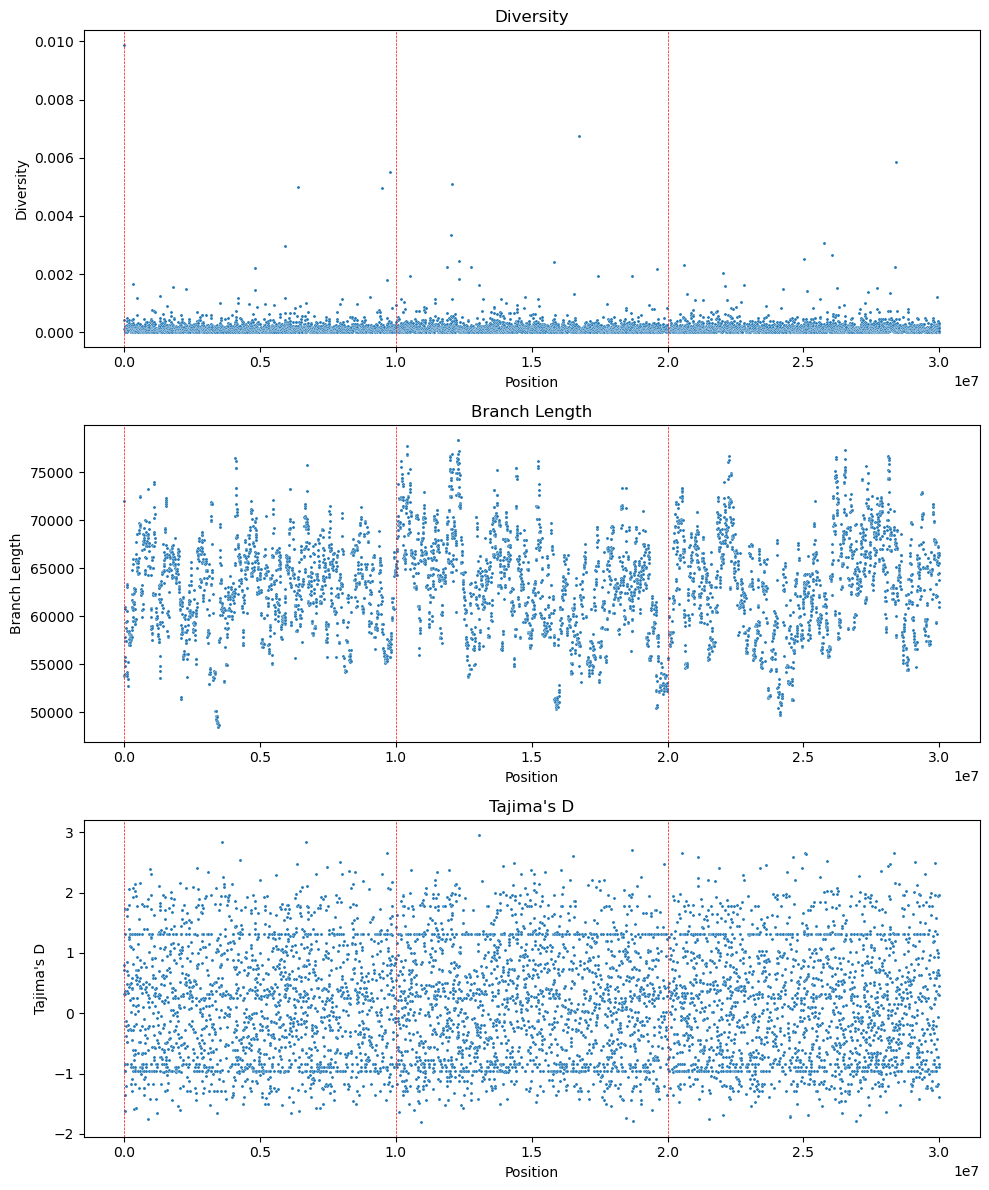

In [30]:
amplicon_intervals = [(2003, 3003), (10003003, 10004003), (20004003, 20005003)]
amplicon_average_positions = [(sum(e) // 2) for e in amplicon_intervals]
amplicon_average_positions
df = df.iloc[:,:4] #taking only relevant columns
num_cols = len(df.columns) - 1
fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(10, num_cols*4))


for i, col in enumerate(df.columns[1:]):
    sns.scatterplot(data=df, x='Position', y=col, ax=axes[i], s=5)   
    axes[i].set_title(f'{col}')
    for vline in amplicon_average_positions:
        axes[i].axvline(x = vline, color='red', linestyle='--', lw = 0.5)

plt.tight_layout()
plt.show()

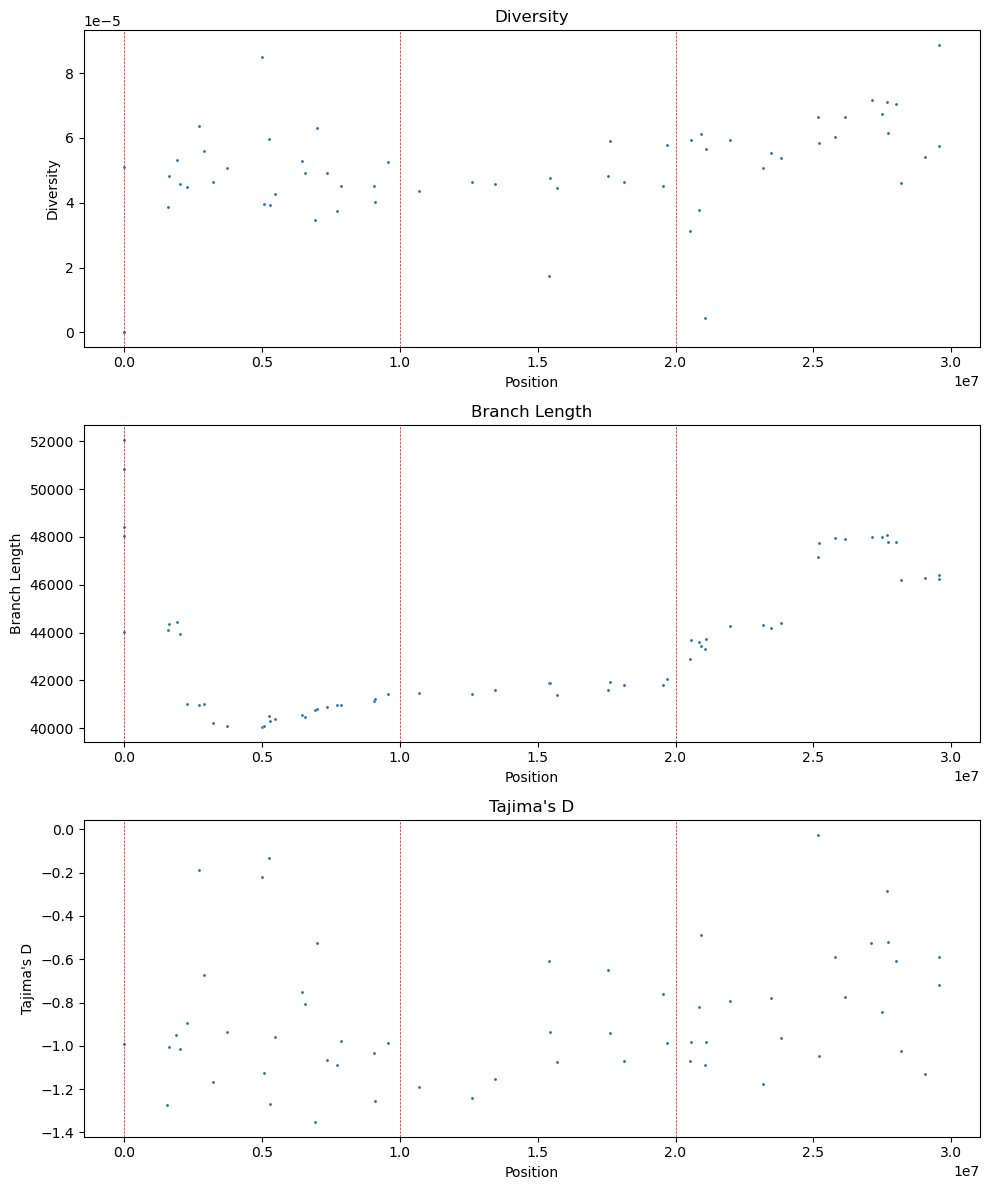

In [18]:
amplicon_intervals = [(2003, 3003), (10003003, 10004003), (20004003, 20005003)]
amplicon_average_positions = [(sum(e) // 2) for e in amplicon_intervals]
amplicon_average_positions
df = df.iloc[:,:4] #taking only relevant columns
num_cols = len(df.columns) - 1
fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(10, num_cols*4))


for i, col in enumerate(df.columns[1:]):
    sns.scatterplot(data=df, x='Position', y=col, ax=axes[i], s=5)   
    axes[i].set_title(f'{col}')
    for vline in amplicon_average_positions:
        axes[i].axvline(x = vline, color='red', linestyle='--', lw = 0.5)

plt.tight_layout()
plt.show()

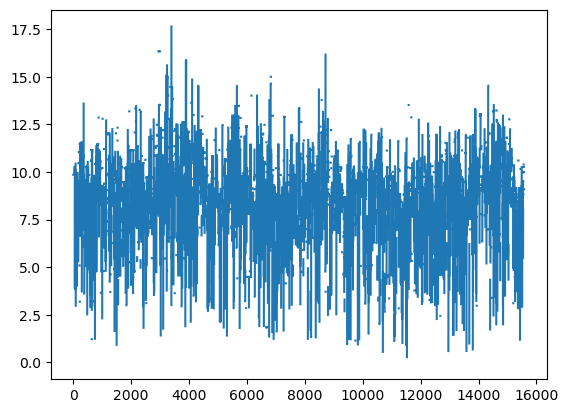

In [35]:
ts1 = tskit.load("../results/A_3__N_1000__u_0.0000050000__r_0.0000000500__S_200_4.trees")
run_stat_logp = kasper_stats.kasper_run_stat(ts1)
plt.plot(run_stat_logp)

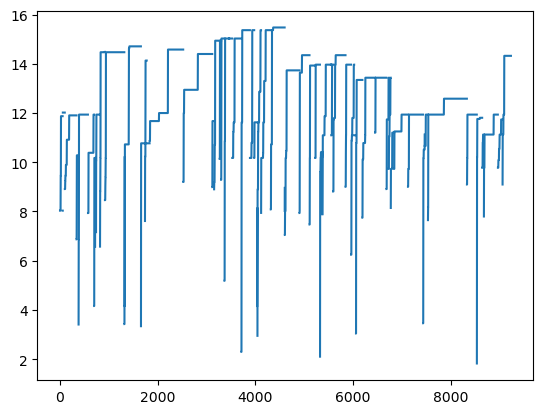

In [26]:
ts1 = tskit.load("../steps/processed_tree_seqs/A_3__N_1000__u_0.0000050000__r_0.0000000005__S_20_4.trees")
run_stat_logp = kasper_stats.kasper_run_stat(ts1)
plt.plot(run_stat_logp)

In [ ]:
#tmrca = [tree.time(tree.root) for tree in ts2.trees() if len(tree.roots) == 1]
c = 0
for tree in ts1.trees():
    #if tree.roots == 1:
    c +=1
    print(tree.time(tree.roots[0]))
#tmrca
c

A_3__N_1000__u_0.0000050000__r_0.0000000005__S_2_3.trees
A_3__N_1000__u_0.0000050000__r_0.0000000500__S_20_0.trees
A_3__N_1000__u_0.0000050000__r_0.0000000000__S_2_1.trees
A_3__N_1000__u_0.0000050000__r_0.0000000500__S_2_3.trees
A_3__N_1000__u_0.0000050000__r_0.0000000005__S_20_4.trees


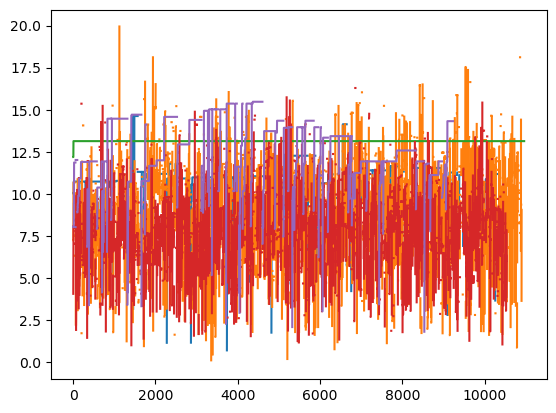

In [27]:
files = os.listdir("../steps/processed_tree_seqs")
l = []
for s in files[20:30]: #in this range we have a good heterogeneity in parameters
    if ".trees" in s:
        print(s)
        l.append("../steps/processed_tree_seqs/" + s) 
ts1 = tskit.load(l[0])
ts2 = tskit.load(l[1])
ts3 = tskit.load(l[2])
ts4 = tskit.load(l[3])
ts5 = tskit.load(l[4])
tss = [ts1, ts2, ts3, ts4, ts5]
for ts in tss:
    run_stat_logp = kasper_stats.kasper_run_stat(ts)
    plt.plot(run_stat_logp)
plt.show()

In [20]:
df1 = pd.read_hdf("../steps/processed_tree_seqs/A_3__N_1000__u_0.0000050000__r_0.0000000500__S_2_2.h5")
df2 = pd.read_hdf("../steps/processed_tree_seqs/A_3__N_1000__u_0.0000050000__r_0.0000000005__S_200_0.h5")
df3 = pd.read_hdf("../steps/processed_tree_seqs/A_3__N_1000__u_0.0000050000__r_0.0000000500__S_20_3.h5")
df4 = pd.read_hdf("../steps/processed_tree_seqs/A_3__N_1000__u_0.0000050000__r_0.0000000000__S_20_1.h5")
df5 = pd.read_hdf("../steps/processed_tree_seqs/A_3__N_1000__u_0.0000050000__r_0.0000000005__S_200_4.h5")
dfs  =[df1, df2, df3, df4, df5]


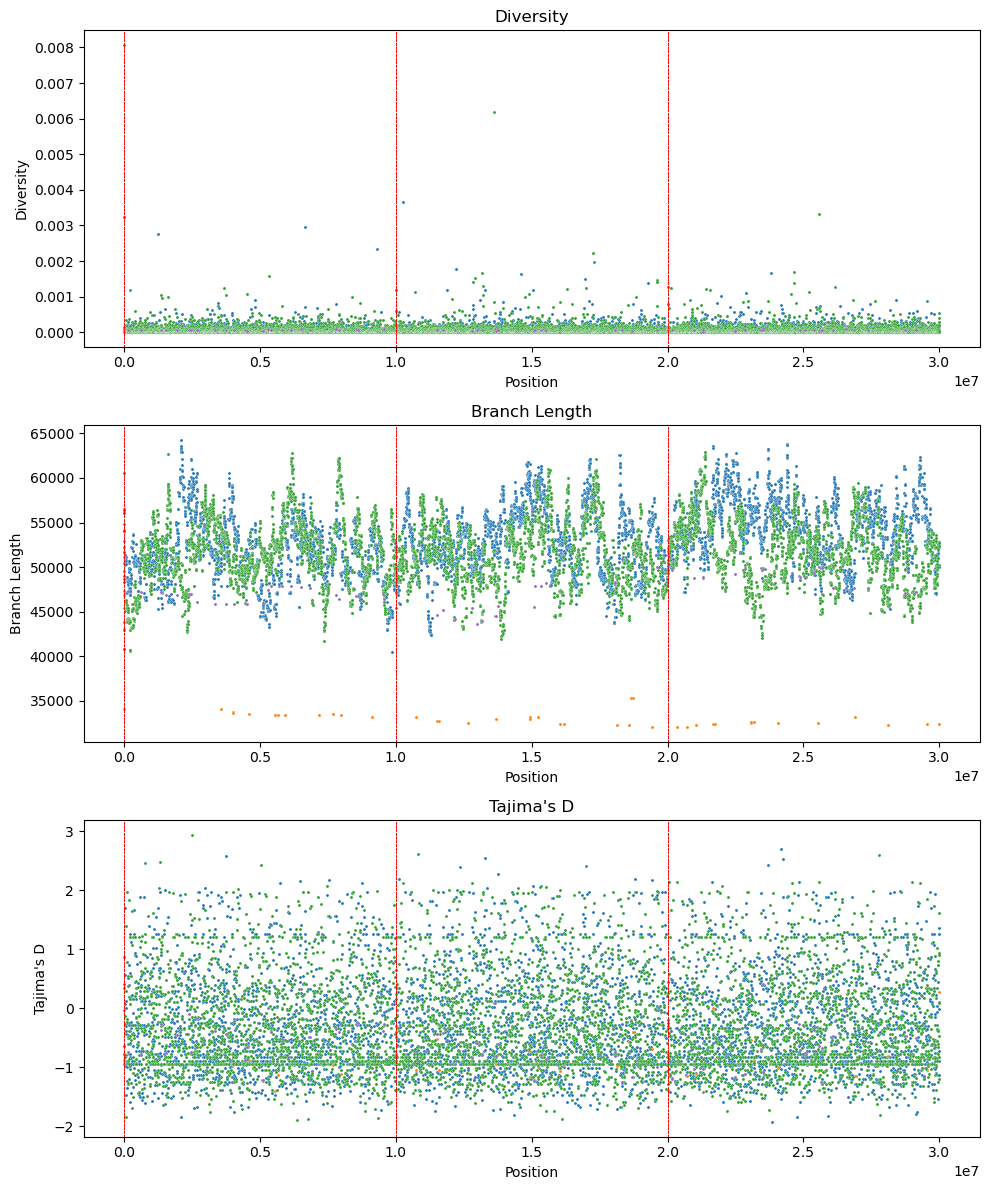

In [21]:
amplicon_intervals = [(2003, 3003), (10003003, 10004003), (20004003, 20005003)]
amplicon_average_positions = [(sum(e) // 2) for e in amplicon_intervals]
df = df.iloc[:,:4] #taking only relevant columns
num_cols = len(df.columns) - 1
fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(10, num_cols*4))

for df in dfs:
        df = df.iloc[:,:4] #taking only relevant columns
        for i, col in enumerate(df.columns[1:]):
            sns.scatterplot(data=df, x='Position', y=col, ax=axes[i], s=5)   
            axes[i].set_title(f'{col}')
            for vline in amplicon_average_positions:
                axes[i].axvline(x = vline, color='red', linestyle='--', lw = 0.5)

plt.tight_layout()
plt.show()